# 08 Forcasting Churn

In [1]:
import json
import sqlalchemy
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from typing import Tuple, List, Dict

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [3]:
import json 

with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())
    # conf = Box(json.loads(f.read()))

chap8 = conf["chap8"]

## Dependent Data

In [4]:
tmp = pd.read_sql_query("SELECT * FROM metric_name ORDER BY metric_name_id", conn)
tmp.tail()

,metric_name_id,metric_name
16,28,unfriend_per_newfriend_scaled
17,30,new_friends_pcnt_change
18,31,days_since_newfriend
19,33,unfriend_28day_avg_84day_obs
20,34,unfriend_28day_avg_84day_obs_scaled


In [5]:
tmp = pd.read_sql_query("SELECT * FROM metric ORDER BY RANDOM() LIMIT 10000", conn)
tmp.head()

,account_id,metric_time,metric_name_id,metric_value
0,5428,2020-05-10,30,3.00000
1,9982,2020-03-01,28,7.00000
2,9513,2020-03-22,6,6.00000
3,4041,2020-04-26,2,86.00000
4,1899,2020-03-15,21,0.78125


## Metric Queries

### Listing 8.0 Observations

In [6]:
from_yyyy_mm_dd = chap8["list0"]["params"]["%from_yyyy-mm-dd"] 
to_yyyy_mm_dd = chap8["list0"]["params"]["%to_yyyy-mm-dd"]
metric_interval = chap8["list0"]["params"]["%metric_interval"]
from_yyyy_mm_dd, to_yyyy_mm_dd, metric_interval

('2020-03-01', '2020-05-10', '7 day')

In [7]:
# listing_8_0_dataset2.sql

query = f"""\
WITH observation_params AS (
    SELECT  
        interval '{metric_interval}' AS metric_period,
        '{from_yyyy_mm_dd}'::timestamp AS obs_start,
        '{to_yyyy_mm_dd}'::timestamp AS obs_end
)

    SELECT 
        m.account_id, 
        o.observation_date, 
        is_churn,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=21 THEN metric_value ELSE 0 END) AS adview_per_post,
        SUM(CASE WHEN metric_name_id=22 THEN metric_value ELSE 0 END) AS reply_per_message,
        SUM(CASE WHEN metric_name_id=23 THEN metric_value ELSE 0 END) AS like_per_post,
        SUM(CASE WHEN metric_name_id=24 THEN metric_value ELSE 0 END) AS post_per_message,
        SUM(CASE WHEN metric_name_id=27 THEN metric_value ELSE 0 END) AS dislike_pcnt,
        SUM(CASE WHEN metric_name_id=28 THEN metric_value ELSE 0 END) AS unfriend_per_newfriend,
        SUM(CASE WHEN metric_name_id=30 THEN metric_value ELSE 0 END) AS newfriend_pcnt_chng,
        SUM(CASE WHEN metric_name_id=31 THEN metric_value ELSE 0 END) AS days_since_newfriend,
        SUM(CASE WHEN metric_name_id=34 THEN metric_value ELSE 0 END) AS unfriend_per_month
      FROM 
        metric AS m 
INNER JOIN 
        observation_params
        ON metric_time BETWEEN obs_start AND obs_end
INNER JOIN observation AS o 
        ON m.account_id = o.account_id
       AND m.metric_time > (o.observation_date - metric_period)::timestamp
       AND m.metric_time <= o.observation_date::timestamp
  GROUP BY 
        m.account_id, metric_time, observation_date, is_churn
  ORDER BY 
        observation_date, m.account_id
"""
res = pd.read_sql_query(query, conn)
res.head()

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,message_per_month,reply_per_month,adview_per_post,reply_per_message,like_per_post,post_per_message,dislike_pcnt,unfriend_per_newfriend,newfriend_pcnt_chng,days_since_newfriend,unfriend_per_month
0,27,2020-03-01,False,48.0,3.0,12.0,6.0,7.0,78.0,36.0,0.500000,0.461538,4.000000,0.153846,0.127273,0.0,0.000000,0.0,0.000000
1,102,2020-03-01,False,40.0,5.0,50.0,16.0,7.0,2.0,1.0,0.320000,0.500000,0.800000,25.000000,0.148936,0.0,0.000000,0.0,1.018182
2,139,2020-03-01,False,15.0,0.0,17.0,10.0,3.0,47.0,21.0,0.588235,0.446809,0.882353,0.361702,0.166667,18.0,0.000000,0.0,0.000000
3,194,2020-03-01,False,19.0,5.0,54.0,139.0,0.0,107.0,36.0,2.574074,0.336449,0.351852,0.504673,0.000000,0.0,-0.444444,0.0,1.018182
4,232,2020-03-01,False,94.0,7.0,12.0,31.0,12.0,2.0,1.0,2.583333,0.500000,7.833334,6.000000,0.113208,0.0,0.400000,0.0,0.000000


In [8]:
res.drop(columns=["is_churn", "account_id", "observation_date"]).describe()\
    .transpose().sort_values("mean")
# expect no row contains 0 mean

,count,mean,std,min,25%,50%,75%,max
newfriend_pcnt_chng,24450.0,0.179551,0.892838,-1.0,-0.250000,0.000000,0.333333,12.0
dislike_pcnt,24450.0,0.216477,0.201080,0.0,0.064815,0.152339,0.313433,1.0
reply_per_message,24450.0,0.256738,0.313804,0.0,0.063341,0.173913,0.342105,8.0
unfriend_per_month,24450.0,0.306416,0.392316,0.0,0.000000,0.000000,0.528302,4.2
days_since_newfriend,24450.0,0.834683,4.706198,0.0,0.000000,0.000000,0.000000,113.0
adview_per_post,24450.0,1.590348,2.341400,0.0,0.432432,0.900000,1.833333,58.5
unfriend_per_newfriend,24450.0,2.420859,12.628524,0.0,0.000000,0.000000,0.000000,348.0
like_per_post,24450.0,3.706322,5.819370,0.0,1.000000,2.038278,4.250000,174.0
post_per_message,24450.0,6.284334,16.943736,0.0,0.428571,1.523810,5.123162,423.6
newfriend_per_month,24450.0,7.363149,8.808748,0.0,2.000000,5.000000,9.000000,162.0


In [9]:
full_df = res.copy()
df = res.copy().drop(columns=["account_id", "observation_date"])
df.shape

(24450, 17)

### Listing 8.3

In [10]:
pprint(chap8["list3"]["params"])

{'%metric_interval': '7 day', 'mode': 'save', 'type': 'sql'}


In [11]:
## listing_8_3_dataset2_current

query = """\
WITH metric_date AS (
    SELECT 
        MAX(metric_time) AS last_metric_time 
      FROM metric
), 
account_tenures AS (
    SELECT 
        account_id, 
        metric_value AS account_tenure
      FROM metric AS m 
INNER JOIN metric_date 
        ON metric_time = last_metric_time
    WHERE metric_name_id = 8
      AND metric_value >= 14
)

    SELECT 
        s.account_id, 
        d.last_metric_time AS observation_date,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=21 THEN metric_value ELSE 0 END) AS adview_per_post,
        SUM(CASE WHEN metric_name_id=22 THEN metric_value ELSE 0 END) AS reply_per_message,
        SUM(CASE WHEN metric_name_id=23 THEN metric_value ELSE 0 END) AS like_per_post,
        SUM(CASE WHEN metric_name_id=24 THEN metric_value ELSE 0 END) AS post_per_message,
        SUM(CASE WHEN metric_name_id=25 THEN metric_value ELSE 0 END) AS unfriend_per_newfriend,
        SUM(CASE WHEN metric_name_id=27 THEN metric_value ELSE 0 END) AS dislike_pcnt,
        SUM(CASE WHEN metric_name_id=30 THEN metric_value ELSE 0 END) AS newfriend_pcnt_chng,
        SUM(CASE WHEN metric_name_id=31 THEN metric_value ELSE 0 END) AS days_since_newfriend,
        SUM(CASE WHEN metric_name_id=34 THEN metric_value ELSE 0 END) AS unfriend_per_month
      FROM 
        metric AS m 
INNER JOIN metric_date AS d 
        ON m.metric_time = d.last_metric_time
INNER JOIN account_tenures AS a 
        ON a.account_id = m.account_id
INNER JOIN subscription AS s 
        ON m.account_id = s.account_id
     WHERE s.start_date <= d.last_metric_time
       AND (s.end_date >= d.last_metric_time OR s.end_date IS null)
  GROUP BY 
        s.account_id, d.last_metric_time
  ORDER BY 
        s.account_id
"""

## Data Preprations

### Listing 8.1 Prepare Data

In [12]:
pprint(chap8["list1"])

{'name': 'prepare_data',
 'params': {'group_corr_thresh': 0.65},
 'v2': {'data_set_path': 'socialnet7/socialnet7_dataset.csv'},
 'v3': {'data_set_path': 'socialnet7/socialnet7_dataset3_nocat.csv'}}


In [13]:
import sys
sys.path.append("/app")

#### 1. Understand stats of metrics

- Especially the skew of data distribution

In [14]:
# from fightchurn.listings.chap5.listing_5_2_dataset_stats import dataset_stats
# dataset_stats??
def dataset_stats(churn_data):
    """Return summary statistics on the observations data"""

    if 'is_churn' in churn_data:
        churn_data['is_churn'] = churn_data['is_churn'].astype(float)

    summary = churn_data.describe()
    summary = summary.transpose()

    summary['skew'] = churn_data.skew()
    summary['1%'] = churn_data.quantile(q=0.01)
    summary['99%'] = churn_data.quantile(q=0.99)
    summary['nonzero'] = churn_data.astype(bool).sum(axis=0) / churn_data.shape[0]

    summary = summary[ ['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max'] ]
    summary.columns = summary.columns.str.replace("%", "pct")
    
    return summary

In [15]:
stats = dataset_stats(df.copy()).sort_values("skew", ascending=False)
# display(stats.index.values)
stats.head(10)

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
days_since_newfriend,24450.0,0.089693,0.834683,4.706198,10.509259,0.0,0.0,0.000000,0.000000,0.000000,22.000000,113.0
unfriend_per_newfriend,24450.0,0.084049,2.420859,12.628524,9.647562,0.0,0.0,0.000000,0.000000,0.000000,59.510000,348.0
post_per_month,24450.0,0.985971,44.892638,81.584549,9.409433,0.0,0.0,9.000000,22.000000,50.000000,344.000000,2384.0
reply_per_month,24450.0,0.794928,8.122781,22.296798,9.108955,0.0,0.0,1.000000,2.000000,6.000000,100.000000,579.0
post_per_message,24450.0,0.951247,6.284334,16.943736,8.879202,0.0,0.0,0.428571,1.523810,5.123162,76.000000,423.6
like_per_month,24450.0,0.993579,105.869611,211.591800,8.126259,0.0,1.0,18.000000,46.000000,109.000000,928.510000,5581.0
message_per_month,24450.0,0.964254,30.849162,68.562317,8.125805,0.0,0.0,5.000000,12.000000,29.000000,309.000000,1511.0
like_per_post,24450.0,0.981104,3.706322,5.819370,7.755867,0.0,0.0,1.000000,2.038278,4.250000,26.000000,174.0
adview_per_month,24450.0,0.978814,42.641227,73.222626,6.103837,0.0,0.0,9.000000,21.000000,47.000000,343.000000,1457.0
adview_per_post,24450.0,0.968221,1.590348,2.341400,5.789795,0.0,0.0,0.432432,0.900000,1.833333,11.244625,58.5


In [16]:
# skewed columns
thresh = 4.0
stats[(stats["skew"] > thresh) & (stats["min"] >= 0)]

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
days_since_newfriend,24450.0,0.089693,0.834683,4.706198,10.509259,0.0,0.0,0.000000,0.000000,0.000000,22.000000,113.0
unfriend_per_newfriend,24450.0,0.084049,2.420859,12.628524,9.647562,0.0,0.0,0.000000,0.000000,0.000000,59.510000,348.0
post_per_month,24450.0,0.985971,44.892638,81.584549,9.409433,0.0,0.0,9.000000,22.000000,50.000000,344.000000,2384.0
reply_per_month,24450.0,0.794928,8.122781,22.296798,9.108955,0.0,0.0,1.000000,2.000000,6.000000,100.000000,579.0
post_per_message,24450.0,0.951247,6.284334,16.943736,8.879202,0.0,0.0,0.428571,1.523810,5.123162,76.000000,423.6
like_per_month,24450.0,0.993579,105.869611,211.591800,8.126259,0.0,1.0,18.000000,46.000000,109.000000,928.510000,5581.0
message_per_month,24450.0,0.964254,30.849162,68.562317,8.125805,0.0,0.0,5.000000,12.000000,29.000000,309.000000,1511.0
like_per_post,24450.0,0.981104,3.706322,5.819370,7.755867,0.0,0.0,1.000000,2.038278,4.250000,26.000000,174.0
adview_per_month,24450.0,0.978814,42.641227,73.222626,6.103837,0.0,0.0,9.000000,21.000000,47.000000,343.000000,1457.0
adview_per_post,24450.0,0.968221,1.590348,2.341400,5.789795,0.0,0.0,0.432432,0.900000,1.833333,11.244625,58.5


In [17]:
# fat-tailed columns
stats[(stats["skew"] > thresh) & (stats["min"] < 0)]
# no pct change metrics here

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max


#### 2. Transform skewed metrics

In [18]:
# 7.3.2 Scores for metrics with extreme outliers (fat tails)
# from fightchurn.listings.chap7.listing_7_5_fat_tail_scores import fat_tail_scores
# fat_tail_scores??

def transform_skew_columns(data, skew_col_names):
    for col in skew_col_names:
        data[col] = np.log(1.0 + data[col])

def transform_fattail_columns(data, fattail_col_names):
    for col in fattail_col_names:
        data[col] = np.log(data[col] + np.sqrt(np.power(data[col],2) + 1.0))

def fat_tail_scores(churn_data, stats, skew_thresh=4.0, **kwargs):
    
    # prepare data
    data_scores = churn_data.copy() 
    data_scores.drop('is_churn', inplace=True, axis=1)

    stats.drop('is_churn', inplace=True)

    # skewed columns, i.e. not evenly distributed
    skewed_columns = (stats['skew'] > skew_thresh) & (stats['min'] >= 0)
    transform_skew_columns(data_scores, skewed_columns[skewed_columns].keys())

    # fat-tail distributed columns, 
    fattail_columns = (stats['skew'] > skew_thresh) & (stats['min'] < 0)
    transform_fattail_columns(data_scores,fattail_columns[fattail_columns].keys())

    # mean and std across rows on each column, i.e. each metric
    mean_vals = data_scores.mean(axis=0)
    std_vals = data_scores.std(axis=0)
    data_scores = (data_scores - mean_vals) / std_vals

    # append the original is_churn values
    data_scores['is_churn'] = churn_data['is_churn']

    param_df = pd.DataFrame({
        'skew_score': skewed_columns, 'fattail_score': fattail_columns, 'mean': mean_vals, 'std': std_vals
    })
    
    return data_scores, param_df

In [19]:
scores, params = fat_tail_scores(df.copy(), stats.copy())

In [20]:
scores.head()

,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,message_per_month,reply_per_month,adview_per_post,reply_per_message,like_per_post,post_per_message,dislike_pcnt,unfriend_per_newfriend,newfriend_pcnt_chng,days_since_newfriend,unfriend_per_month,is_churn
0,0.046968,-0.495320,-0.465733,-0.909324,-0.177503,1.406526,1.997239,-0.648489,0.652640,0.529170,-1.007845,-0.443625,-0.286460,-0.201102,-0.278495,-0.781045,False
1,-0.089395,-0.268273,0.677792,-0.180826,-0.177503,-1.204436,-0.600059,-0.881792,0.775205,-0.876925,1.937971,-0.335889,-0.286460,-0.201102,-0.278495,1.814266,False
2,-0.809267,-0.835891,-0.193485,-0.538233,-0.830230,1.008798,1.534464,-0.544171,0.605700,-0.815355,-0.851206,-0.247713,3.132593,-0.201102,-0.278495,-0.781045,False
3,-0.638558,-0.268273,0.740961,1.550248,-2.135683,1.656127,1.997239,0.936099,0.254015,-1.270974,-0.756789,-1.076572,-0.286460,-0.698891,-0.278495,1.814266,False
4,0.553455,-0.041226,-0.465733,0.338491,0.279693,-1.204436,-0.600059,0.940821,0.775205,1.312412,0.697051,-0.513573,-0.286460,0.246908,-0.278495,-0.781045,False


In [21]:
params
# pct change metrics are more likely to be fat-tail distributed

,skew_score,fattail_score,mean,std
adview_per_month,True,False,3.053457,1.217989
adview_per_post,True,False,0.760791,0.547929
days_since_newfriend,True,False,0.166316,0.597194
dislike_pcnt,False,False,0.216477,0.201080
dislike_per_month,True,False,2.267937,1.061926
like_per_month,True,False,3.830426,1.307154
like_per_post,True,False,1.224950,0.726588
message_per_month,True,False,2.607448,1.252732
newfriend_pcnt_chng,False,False,0.179551,0.892838
newfriend_per_month,False,False,7.363149,8.808748


#### 3. Combine correlated metrics to groups

In [22]:
group_corr_thresh = chap8["list1"]["params"]["group_corr_thresh"]
group_corr_thresh

0.65

In [23]:
# from fightchurn.listings.chap6.listing_6_4_find_metric_groups import find_metric_groups
# find_metric_groups??
from fightchurn.listings.chap6.listing_6_4_find_metric_groups import (
    find_correlation_clusters, 
    # relabel_clusters, make_load_matrix
)
# rewritten functions, see 06 notebook

def _relabel_clusters(metric_cluster_labels: npt.NDArray, metric_names: List[str]):
    """Export a DataFrame of cluter label and assigned group for each metric"""
    
    metric_groups = pd.DataFrame({
        "cluster_label": map(lambda v: f"cluster-{v}", metric_cluster_labels), 
        "metric": metric_names
    })
    
    # group by each cluster, and then assign group id and name
    groups = (
        metric_groups
        .groupby("cluster_label", as_index=True).agg({"metric": [("metric_counts", len), ("metrics", list)]})
        .droplevel(0, axis=1)
        .reset_index()
        .sort_values("metric_counts", ascending=False, ignore_index=True)
        .reset_index().rename(columns={"index": "group_id"})
        .assign(group_name=lambda d: d.apply(
            lambda d: d.metrics[0] if len(d.metrics) == 1 else f"metric_group_{d.group_id}", axis=1
        ))
        .reindex(columns=["group_id", "group_name", "cluster_label", "metrics", "metric_counts"])    
    )
    
    # add group id and name for each metric group
    metric_groups = (
        metric_groups.assign(
            group_id=lambda d: d.cluster_label.map(
                dict(groups[["cluster_label", "group_id"]].to_dict(orient="split")["data"])
            ),
            group_name=lambda d: d.cluster_label.map(
                dict(groups[["cluster_label", "group_name"]].to_dict(orient="split")["data"])
            )
        )
        .sort_values("group_id", ignore_index=True)
    )
    
    return metric_groups, groups

def _make_load_matrix(
    metric_groups: pd.DataFrame, groups: pd.DataFrame, threshold: float
):
    loading_matrix = pd.DataFrame(0.0, index=metric_groups.metric, columns=groups.group_name)

    # iterate each metric group
    for name in groups.group_name: 

        # get the list of metrics in the group
        metrics = groups.query("group_name == @name").metrics.values[0]

        # weight depends on number of metrics
        if len(metrics) > 1: 
            weight = 1.0 / (np.sqrt(threshold) * len(metrics))
        else: 
            weight = 1.0
        loading_matrix.loc[metrics, name] = weight

    return loading_matrix
    


def find_metric_groups(scored_data: pd.DataFrame, corr_threshold: float=0.5):
    """Use hierarchy clustering to combine corrrelated metrics"""

    # scored = scored_data.drop(columns=["is_churn", "account_id", "observation_date"])
    scored = scored_data.drop(columns=["is_churn"])
    metric_names = scored.columns.tolist()
    
    # cluster labels for each metric
    cluster_labels = find_correlation_clusters(scored.corr(), corr_threshold)
    # group metrics by clustering result
    metric_cluster_groups, cluster_groups = _relabel_clusters(cluster_labels, metric_names)
    # create loading matrix
    loading_matrix = _make_load_matrix(metric_cluster_groups, cluster_groups, corr_threshold)
    
    return loading_matrix, metric_cluster_groups, cluster_groups

weight_matrix, metric_groups, groups = find_metric_groups(scores.copy(), group_corr_thresh)

In [24]:
weight_matrix

group_name,metric_group_0,metric_group_1,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message
metric,,,,,,,,,,,,,
like_per_month,0.413449,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
post_per_month,0.413449,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adview_per_month,0.413449,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
message_per_month,0.000000,0.620174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
reply_per_month,0.000000,0.620174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
newfriend_pcnt_chng,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unfriend_per_newfriend,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
days_since_newfriend,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unfriend_per_month,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
with pd.option_context('display.max_colwidth', 120):
    display(metric_groups)
# first metric group contains 3 metrics

,cluster_label,metric,group_id,group_name
0,cluster-1,like_per_month,0,metric_group_0
1,cluster-1,post_per_month,0,metric_group_0
2,cluster-1,adview_per_month,0,metric_group_0
3,cluster-8,message_per_month,1,metric_group_1
4,cluster-8,reply_per_month,1,metric_group_1
5,cluster-10,newfriend_pcnt_chng,2,newfriend_pcnt_chng
6,cluster-11,unfriend_per_newfriend,3,unfriend_per_newfriend
7,cluster-12,days_since_newfriend,4,days_since_newfriend
8,cluster-13,unfriend_per_month,5,unfriend_per_month
9,cluster-2,post_per_message,6,post_per_message


In [26]:
with pd.option_context('display.max_colwidth', 120):
    display(groups)

,group_id,group_name,cluster_label,metrics,metric_counts
0,0,metric_group_0,cluster-1,"[like_per_month, post_per_month, adview_per_month]",3
1,1,metric_group_1,cluster-8,"[message_per_month, reply_per_month]",2
2,2,newfriend_pcnt_chng,cluster-10,[newfriend_pcnt_chng],1
3,3,unfriend_per_newfriend,cluster-11,[unfriend_per_newfriend],1
4,4,days_since_newfriend,cluster-12,[days_since_newfriend],1
5,5,unfriend_per_month,cluster-13,[unfriend_per_month],1
6,6,post_per_message,cluster-2,[post_per_message],1
7,7,newfriend_per_month,cluster-3,[newfriend_per_month],1
8,8,adview_per_post,cluster-4,[adview_per_post],1
9,9,like_per_post,cluster-5,[like_per_post],1


#### 4. Transform data with group metrics

In [27]:
# from fightchurn.listings.chap6.listing_6_3_apply_metric_groups import apply_metric_groups
# apply_metric_groups??

def apply_metric_groups(score_data: pd.DataFrame, loading_matrix: pd.DataFrame):
    """Matrix mutiplication on normalized data and weight matrix"""
    
    mat_mul_result = np.matmul(
        # only columns that are in loading_matrix index and ensure order the same
        score_data.reindex(columns=loading_matrix.index.values).values,
        # weight matrix with groups in coumns and metrix in index
        loading_matrix.values
    )
    
    grouped_score_data = pd.DataFrame(
        mat_mul_result, index=score_data.index, columns=loading_matrix.columns
    ).assign(is_churn=score_data.is_churn)
    
    return grouped_score_data


In [28]:
grouped_scores = apply_metric_groups(scores, weight_matrix)
grouped_scores.head()

group_name,metric_group_0,metric_group_1,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message,is_churn
0,-0.549097,2.110926,-0.201102,-0.286460,-0.278495,-0.781045,-1.007845,-0.495320,-0.648489,0.529170,-0.177503,-0.443625,0.652640,False
1,0.168510,-1.119100,-0.201102,-0.286460,-0.278495,1.814266,1.937971,-0.268273,-0.881792,-0.876925,-0.177503,-0.335889,0.775205,False
2,-0.637119,1.577264,-0.201102,3.132593,-0.278495,-0.781045,-0.851206,-0.835891,-0.544171,-0.815355,-0.830230,-0.247713,0.605700,False
3,0.683287,2.265722,-0.698891,-0.286460,-0.278495,1.814266,-0.756789,-0.268273,0.936099,-1.270974,-2.135683,-1.076572,0.254015,False
4,0.176218,-1.119100,0.246908,-0.286460,-0.278495,-0.781045,0.697051,-0.041226,0.940821,1.312412,0.279693,-0.513573,0.775205,False


In [29]:
grouped_scores.describe().transpose()[["mean", "std"]].round(6)
# the mean of each metric group is 0 AND standard deviation is 1
# i.e. for an observation of average engaged user, the total engagement is 0

,mean,std
group_name,,
metric_group_0,-0.0,1.092693
metric_group_1,0.0,1.181083
newfriend_pcnt_chng,-0.0,1.000000
unfriend_per_newfriend,-0.0,1.000000
days_since_newfriend,-0.0,1.000000
unfriend_per_month,-0.0,1.000000
post_per_message,0.0,1.000000
newfriend_per_month,-0.0,1.000000
adview_per_post,-0.0,1.000000


In [30]:
# from fightchurn.listings.chap6.listing_6_5_ordered_correlation_matrix import ordered_correlation_matrix
# ordered_correlation_matrix??
def ordered_correlation_matrix(churn_data, load_mat_df):

    churn_data = churn_data[load_mat_df.index.values]
    corr = churn_data.corr()
    
    # save_name = data_set_path.replace('.csv', '_ordered_correlation_matrix.csv')
    return corr

In [31]:
ordered_correlation_matrix(df, weight_matrix).head()

,like_per_month,post_per_month,adview_per_month,message_per_month,reply_per_month,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message
like_per_month,1.000000,0.505317,0.505503,0.046903,0.009799,-0.000145,-0.045222,-0.047182,-0.000213,0.247426,0.508099,-0.007795,0.234592,0.309351,-0.280945,-0.038436
post_per_month,0.505317,1.000000,0.503433,0.032563,0.008548,0.000689,-0.061874,-0.051442,0.014221,0.499473,0.544962,-0.150865,-0.127769,0.331452,-0.153335,-0.040229
adview_per_month,0.505503,0.503433,1.000000,0.042342,0.021643,0.001207,-0.066973,-0.052738,0.003334,0.228112,0.533490,0.232197,0.015175,0.328143,-0.160855,-0.035345
message_per_month,0.046903,0.032563,0.042342,1.000000,0.848698,0.003197,-0.006161,-0.011436,0.017578,-0.129382,0.035575,0.013977,0.011008,0.076309,0.022471,0.008757
reply_per_month,0.009799,0.008548,0.021643,0.848698,1.000000,0.003477,0.002242,-0.005651,0.018968,-0.107340,0.004463,0.010553,-0.006253,0.047429,0.023441,0.157803


## Modelling

### Listing 8.2 Logistic Regression

- 8.3 Fitting a churn model
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [32]:
pprint(chap8["list2"])

{'name': 'logistic_regression', 'params': {}, 'v1': {'as_retention': False}}


In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
def prepare_data(grouped_data: pd.DataFrame, as_retention: bool  = True) \
    -> Tuple[pd.DataFrame, pd.Series]:
    """Prepare data as X and y, with option to convert churn rate to retention rate"""
    
    X = grouped_data.drop(columns=['is_churn'])
    
    # as churn
    y = grouped_data['is_churn'].astype(int)
    
    # convert y values to retention, n.b. retention rate + churn rate = 1
    if as_retention: 
        # `is_churn = False` converted to `is_retained = True`
        y = np.subtract(1, y).rename("is_retained")
    
    return X, y
X, y = prepare_data(grouped_scores, as_retention=True)
X.shape, y.shape, y.name

((24450, 13), (24450,), 'is_retained')

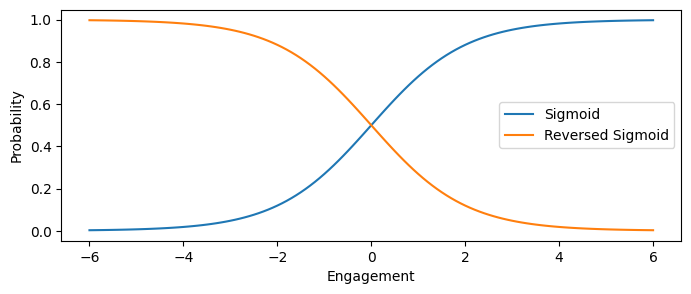

In [35]:
import matplotlib.pyplot as plt

def sigmoid(x: npt.NDArray, rev: bool = False) -> npt.NDArray:
    """S (Sigmoid) curve with logistic, with optional reversed argument"""
    
    # retention probability?
    probs =  1.0 / (1.0 + np.exp(-x))
    if rev: 
    # churn probability?
        return 1 - probs
        
    return probs

x = np.arange(-6, 6.1, 0.1) # engagement values, from -6 to +6
y = sigmoid(x); rev_y = sigmoid(x, rev=True)

plt.subplots(figsize=(8, 3))
plt.plot(x, y, label="Sigmoid")
plt.plot(x, rev_y, label="Reversed Sigmoid")
plt.xlabel("Engagement"); plt.ylabel("Probability"); plt.legend()
plt.show()
# the plot shows the sigmoid curve and reversed sigmoid curve
# sigmoid curve should be about retention, i.e. increase engagement will increase retetenion probabilty
# reversed sigmoid curve can be interpreted as: increase engagement will reduce churn probablity
# and average engaged user (total engagement = 0) should have 0.5 for both retention and churn probabilty

In [36]:
def calculate_retention_impacts(model: LogisticRegression) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    logistict regression model is: logit(p) = β0 + β1x1 + β2x2 + ... + βnxn
    where 
        β0 is the bias (intercept) term 
        β1...βn are the weights (coefficients)
    
    N.B. the give scored group metrics have been processed to have mean=0 and std=1
    
    OUTPUTS:
      metric_retain_impacts - marginal probability for a metric having 1 std higher than average
      average_retain_prob - probability of retention for an average observation (all metric have value = 0)
    """
    
    n_feat = model.n_features_in_
    coefs = model.coef_[0]
    intercept = model.intercept_
    
    # Average observation is when every metric equals to mean (0)
    average_obs =  np.zeros((n_feat, ))
    
    average_retain_prob = sigmoid(np.dot(average_obs, coefs) + intercept)
    
    # Only one metric has value=1, others are 0
    # n.b. since std=1, it also means the observation is 1 std higher than average on that given metric
    only_one_metric_obs = pd.DataFrame(np.eye(n_feat)) # each column is a metric group, each row is a pseudo observation
    
    metric_retain_probs = []
    for idx, row in only_one_metric_obs.iterrows():
        metric_retain_probs.append(sigmoid(np.dot(row.values, coefs) + intercept))
    metric_retain_probs = np.array(metric_retain_probs)
    
    # For each metric, get its marginal impact on retention probabilty, comparing to average
    # n.b. since data is 1 std higher than average, it's 1 std impact
    metric_retain_impacts = metric_retain_probs.ravel() - average_retain_prob
    
    return metric_retain_impacts, average_retain_prob

In [37]:
def save_regression_summary(model: LogisticRegression, cluster_groups: pd.DataFrame) -> pd.DataFrame:
    
    one_stdev_impact, average_retain = calculate_retention_impacts(model)
    
    model_summary = pd.DataFrame.from_dict({
        'group_metric_offset':  np.append(cluster_groups.index,'offset'), 
        'weight': np.append(model.coef_[0], model.intercept_), 
        'retain_impact' : np.append(one_stdev_impact, average_retain), 
        'group_metrics' : np.append(cluster_groups.metrics, '(baseline)')
    })
    
    return model_summary

def save_dataset_predictions(model: LogisticRegression, X: pd.DataFrame) -> pd.DataFrame:
    
    preds = model.predict_proba(X)
    predictions = pd.DataFrame(
        preds, index=X.index, columns=['churn_prob','retain_prob']
        # preds has two columns, class=0 and class=1
    )
    
    return predictions

In [38]:
def logistic_regression(grouped_data, cluster_groups, as_retention=True):
    
    # get X and y as training data
    # default to convert to is_retained
    X, y = prepare_data(grouped_data, as_retention=as_retention)
    
    # fit model with training data
    model = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
    model.fit(X, y)
    
    # export summary
    summary = save_regression_summary(model, cluster_groups)
    # export predictions
    preds = save_dataset_predictions(model, X)
    
    return (X, y), model, summary, preds

In [39]:
(X, y), model, model_summary, predictions = logistic_regression(
    grouped_scores, groups, as_retention=True
)
model

LogisticRegression(penalty='l1', solver='liblinear')

In [40]:
np.c_[X.columns, model.coef_[0].round(6)]
# each model coefficient is the "wegiht" of a metric group, 
# multiply together than you get total engagement for a given observation
# then the total engagement is converted to probablity with sigmoid function

array([['metric_group_0', 0.336881],
       ['metric_group_1', 0.675149],
       ['newfriend_pcnt_chng', 0.119291],
       ['unfriend_per_newfriend', -0.302776],
       ['days_since_newfriend', 0.201132],
       ['unfriend_per_month', -0.124779],
       ['post_per_message', 0.0],
       ['newfriend_per_month', 0.230742],
       ['adview_per_post', -0.465637],
       ['like_per_post', 0.218955],
       ['dislike_per_month', -0.007726],
       ['dislike_pcnt', -0.154719],
       ['reply_per_message', -0.026795]], dtype=object)

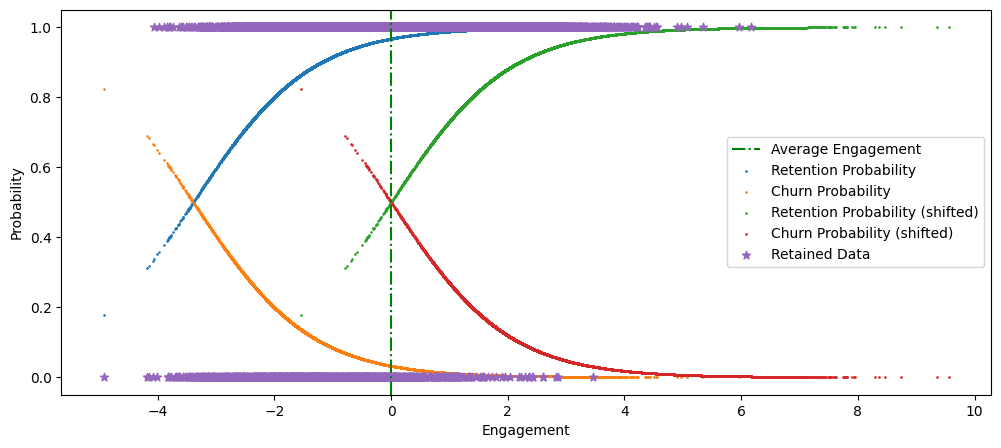

In [41]:
# plot to understand the relationships
engagements = np.dot(X.values, model.coef_[0])
retention_probs = sigmoid(engagements + model.intercept_, rev=False)
# churn_probs = sigmoid(engagements + model.intercept_, rev=True)
churn_probs = 1 - retention_probs # same as above

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(x=engagements, y=retention_probs, s=.8, label="Retention Probability")
ax.scatter(x=engagements, y=churn_probs, s=.8, label="Churn Probability")

ax.scatter(x=engagements + model.intercept_, y=retention_probs, s=.8, label="Retention Probability (shifted)")
ax.scatter(x=engagements + model.intercept_, y=churn_probs, s=.8, label="Churn Probability (shifted)")

ax.scatter(x=engagements, y=y, marker="*", label="Retained Data")
ax.axvline(x=0, color="green", linestyle="-.", label="Average Engagement")
ax.set_xlabel("Engagement"); ax.set_ylabel("Probability")
ax.legend()
fig.show()

Notes 

- By default, the logistict function (`sigmoid`) is expecting dot product on "X" and "coefficients" plus "intercept" term
- However, the average retained observations (.5) is not centered around 0
- So introduce the intercept (bias) term to shift the curve
- After shitfing, both retention and churn curves intersected at Engagment=0 and .5 Probabilty
- Plot the data points show that there're some distribution difference on "is_retained" 
  - Higher Engagement kind of correlated with more "is_retained"

In [42]:
with pd.option_context('display.max_colwidth', 120, "precision", 4):
    display(
        model_summary.assign(retain_impact=lambda d: (d.retain_impact * 100))
        .rename(columns={"weight": "coefficient", "retain_impact": "metric_retention_marginal_impact"})
        .sort_values("metric_retention_marginal_impact", ascending=False)
        .style.format({"metric_retention_marginal_impact": "{:,.4f}%".format,})
    )
# default is 50

,group_metric_offset,coefficient,metric_retention_marginal_impact,group_metrics
13,offset,3.3925,96.7468%,(baseline)
1,1,0.6751,1.5702%,"['message_per_month', 'reply_per_month']"
0,0,0.3369,0.9086%,"['like_per_month', 'post_per_month', 'adview_per_month']"
7,7,0.2307,0.6529%,['newfriend_per_month']
9,9,0.2190,0.6229%,['like_per_post']
4,4,0.2011,0.5769%,['days_since_newfriend']
2,2,0.1193,0.3552%,['newfriend_pcnt_chng']
6,6,0.0000,0.0000%,['post_per_message']
10,10,-0.0077,-0.0244%,['dislike_per_month']
12,12,-0.0268,-0.0854%,['reply_per_message']


Notes on the weights and retain impacts

- weights
  - positive indicates it's associated with increasing engagement
  - negative indicates that it is associated with decreasing engagement
- retention impacts
  - the difference that it makes to the retention probability 
  - for a customer to be one standard deviation above the average in this metric
  - assuming that all the other metrics are exactly average.
  - if impact is 2%
    - customer who is one standard deviation above average on the given metric 
    - has a forcast retention probablity 2% higher than average retention probability
    - or, 2% less than the average churn probability
    



### Listing 8.4 Rescore Metrics

In [ ]:
import os
import pandas as pd
import numpy as np

from fightchurn.listings.chap7.listing_7_5_fat_tail_scores import (
    transform_fattail_columns, transform_skew_columns
)

In [ ]:
def rescore_metrics(data_set_path):

    load_mat_df = reload_churn_data(data_set_path,'load_mat','6.4',is_customer_data=False)
    score_df = reload_churn_data(data_set_path,'score_params','7.5',is_customer_data=False)
    current_data = reload_churn_data(data_set_path,'current','8.3',is_customer_data=True)
    assert set(score_df.index.values)==set(current_data.columns.values),"Data to re-score does not match transform params"
    assert set(load_mat_df.index.values)==set(current_data.columns.values),"Data to re-score does not match lodaasasdfasdfasdf matrix"

    transform_skew_columns(current_data,score_df[score_df['skew_score']].index.values)
    transform_fattail_columns(current_data,score_df[score_df['fattail_score']].index.values)
    scaled_data = score_current_data(current_data,score_df,data_set_path)
    grouped_data = group_current_data(scaled_data, load_mat_df,data_set_path)
    save_segment_data(grouped_data,current_data,load_mat_df,data_set_path)

def score_current_data(current_data,score_df, data_set_path):
    current_data=current_data[score_df.index.values]
    scaled_data=(current_data-score_df['mean'])/score_df['std']
    score_save_path=data_set_path.replace('.csv','_current_scores.csv')
    scaled_data.to_csv(score_save_path,header=True)
    print('Saving score results to %s' % score_save_path)
    return scaled_data

def group_current_data(scaled_data,load_mat_df,data_set_path):
    scaled_data = scaled_data[load_mat_df.index.values]
    grouped_ndarray = np.matmul(scaled_data.to_numpy(), load_mat_df.to_numpy())
    current_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=scaled_data.index)
    score_save_path=data_set_path.replace('.csv','_current_groupscore.csv')
    current_data_grouped.to_csv(score_save_path,header=True)
    print('Saving grouped results to %s' % score_save_path)
    return current_data_grouped

def save_segment_data(current_data_grouped, current_data, load_mat_df, data_set_path):
    group_cols =  load_mat_df.columns[load_mat_df.astype(bool).sum(axis=0) > 1]
    no_group_cols = load_mat_df.columns[load_mat_df.astype(bool).sum(axis=0) == 1]
    segment_df = current_data_grouped[group_cols].join(current_data[no_group_cols])
    segment_df.to_csv(data_set_path.replace('.csv','_current_groupmets_segment.csv'),header=True)

def reload_churn_data(data_set_path,suffix,listing,is_customer_data):
    data_path = data_set_path.replace('.csv', '_{}.csv'.format(suffix))
    assert os.path.isfile(data_path),'You must run listing {} to save {} first'.format(listing,suffix)
    ic = [0,1] if is_customer_data else 0
    churn_data = pd.read_csv(data_path, index_col=ic)
    return churn_data

### Listing 8.5 Churn Prediction

In [ ]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from fightchurn.listings.chap8.listing_8_4_rescore_metrics import reload_churn_data

def churn_forecast(data_set_path,model_name='logreg_model'):

    pickle_path = data_set_path.replace('.csv', '_{}.pkl'.format(model_name))
    assert os.path.isfile(pickle_path), 'You must run listing 8.2 to save a logistic regression model first'
    with open(pickle_path, 'rb') as fid:
        logreg_model = pickle.load(fid)

    current_score_df = reload_churn_data(data_set_path,'current_groupscore','8.4',is_customer_data=True)

    predictions = logreg_model.predict_proba(current_score_df.to_numpy())

    predict_df = pd.DataFrame(predictions, index=current_score_df.index, columns=['churn_prob', 'retain_prob'])
    forecast_save_path = data_set_path.replace('.csv', '_current_predictions.csv')
    print('Saving results to %s' % forecast_save_path)
    predict_df.to_csv(forecast_save_path, header=True)

    forecast_histogram(data_set_path,predict_df)

def forecast_histogram(data_set_path,predict_df,ext='reg'):
    plt.figure(figsize=[6,4])
    n, bins,_ = plt.hist(predict_df['churn_prob'].values,bins=20)
    plt.xlabel('Churn Probability')
    plt.ylabel('# of Accounts')
    plt.title('Histogram of Active Customer Churn Probability ({})'.format(ext))
    plt.grid()
    plt.savefig(data_set_path.replace('.csv', '_{}_churnhist.png'.format(ext)), format='png')
    plt.close()
    hist_df=pd.DataFrame({'n':n,'bins':bins[1:]})
    hist_df.to_csv(data_set_path.replace('.csv', '_current_churnhist.csv'))


### Listing 8.6 Rescore Metrics

In [ ]:
import pandas as pd
import numpy as np
from fightchurn.listings.chap7.listing_7_5_fat_tail_scores import transform_fattail_columns, transform_skew_columns
from fightchurn.listings.chap8.listing_8_4_rescore_metrics import reload_churn_data

def clip_hi_cols(data, hi_vals):
    for col in hi_vals.index.values:
        data.loc[data[col] > hi_vals[col],col] = hi_vals[col]

def clip_lo_cols(data, lo_vals):
    for col in lo_vals.index.values:
        data.loc[data[col] < lo_vals[col],col] = lo_vals[col]

def rescore_metrics(data_set_path):

    current_data = reload_churn_data(data_set_path,'current','8.3',is_customer_data=True)
    load_mat_df = reload_churn_data(data_set_path,'load_mat','6.4',is_customer_data=False)
    score_df = reload_churn_data(data_set_path,'score_params','7.5',is_customer_data=False)
    stats = reload_churn_data(data_set_path,'summarystats','5.2',is_customer_data=False)
    stats.drop('is_churn',inplace=True)
    assert set(score_df.index.values)==set(current_data.columns.values),"Data to re-score does not match transform params"
    assert set(load_mat_df.index.values)==set(current_data.columns.values),"Data to re-score does not match load matrix"
    assert set(stats.index.values)==set(current_data.columns.values),"Data to re-score does not match summary stats"

    clip_hi_cols(current_data, stats['99pct'])
    clip_lo_cols(current_data, stats['1pct'])

    transform_skew_columns(current_data, score_df[score_df['skew_score']].index.values)
    transform_fattail_columns(current_data, score_df[score_df['skew_score']].index.values)

    current_data=current_data[score_df.index.values]
    scaled_data=(current_data-score_df['mean'])/score_df['std']

    scaled_data = scaled_data[load_mat_df.index.values]
    grouped_ndarray = np.matmul(scaled_data.to_numpy(), load_mat_df.to_numpy())

    current_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=current_data.index)

    score_save_path=data_set_path.replace('.csv','_current_groupscore.csv')
    current_data_grouped.to_csv(score_save_path,header=True)
    print('Saving results to %s' % score_save_path)


